<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/modern_approach/transformer/solving_math_word_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solving Math Word Problems with a Seq2Seq Transformer
##Import bibliotek

In [24]:
import pathlib
import random
import string
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

##Załadowanie danych

In [ ]:
!git clone https://github.com/openai/grade-school-math

In [3]:
%cd grade-school-math/grade_school_math/data
%ls

/content/grade-school-math/grade_school_math/data
example_model_solutions.jsonl  test_socratic.jsonl  train_socratic.jsonl
test.jsonl                     train.jsonl


In [4]:
def read_jsonl(path: str):
  with open(path) as fh:
    return [json.loads(line) for line in fh.readlines() if line]

train = read_jsonl('train.jsonl')
test = read_jsonl('test.jsonl')
print(len(train), 'training pairs')
print(len(test), 'test pairs')

7473 training pairs
1319 test pairs


In [5]:
print(train[0])

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}


In [14]:
train_pairs = []
for line in train:
  question = line['question']
  answer = '[start] ' + line['answer'] + ' [end]'
  train_pairs.append((question, answer))

test_pairs = []
for line in test:
  question = line['question']
  answer = '[start] ' + line['answer'] + ' [end]'
  test_pairs.append((question, answer))

for _ in range(5):
  print(random.choice(train_pairs))

('Elena has 8 lilies and 5 tulips in her garden. Each lily has 6 petals. Each tulip has 3 petals. How many flower petals are in Elena’s garden?', '[start] Elena has 8 * 6 = <<8*6=48>>48 lily petals\nElena has 5 * 3 = <<5*3=15>>15 tulip petals\nElena has a total of 48 + 15 = <<48+15=63>>63 petals\n#### 63 [end]')
('A shopkeeper bought 150 packets of milk. Each packet contained 250 ml of milk. If one fluid ounce is equal to 30 ml, how many ounces of milk did he buy?', '[start] If the shopkeeper bought 150 packets of milk, each packet containing 250ml of milk, all the packets had a total of 250*150 =<<150*250=37500>>37500ml\nSince one ounce equal 30 ml, the total amount of milk that the shopkeeper bought in oz is 37500/30=<<37500/30=1250>>1250 oz of milk\n#### 1250 [end]')
('Lee mows one lawn and charges $33. Last week he mowed 16 lawns and three customers each gave him a $10 tip. How many dollars did Lee earn mowing lawns last week?', '[start] 33 * 16 = $<<33*16=528>>528\n3 * 10 = $<<3*1

In [19]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 100
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


question_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
answer_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_questions = [pair[0] for pair in train_pairs]
train_answers = [pair[1] for pair in train_pairs]
question_vectorization.adapt(train_questions)
answer_vectorization.adapt(train_answers)

In [8]:
def format_dataset(question, answer):
    question = question_vectorization(question)
    answer = answer_vectorization(answer)
    return ({"encoder_inputs": question, "decoder_inputs": answer[:, :-1],}, answer[:, 1:])


def make_dataset(pairs):
    question_texts, answer_texts = zip(*pairs)
    question_texts = list(question_texts)
    answer_texts = list(answer_texts)
    dataset = tf.data.Dataset.from_tensor_slices((question_texts, answer_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
# val_ds = make_dataset(val_pairs)

##Budowa modelu

In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

##Wektoryzacja danych

In [10]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [23]:
epochs = 200

transformer.compile(
    'rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy']
)
history = transformer.fit(train_ds, epochs=epochs)

Epoch 1/200
117/117 [==============================] - 18s 114ms/step - loss: 2.4880 - accuracy: 0.6189
Epoch 2/200
117/117 [==============================] - 13s 114ms/step - loss: 2.3219 - accuracy: 0.6473
Epoch 3/200
117/117 [==============================] - 13s 114ms/step - loss: 2.2391 - accuracy: 0.6598
Epoch 4/200
117/117 [==============================] - 14s 116ms/step - loss: 2.1839 - accuracy: 0.6688
Epoch 5/200
117/117 [==============================] - 14s 115ms/step - loss: 2.1314 - accuracy: 0.6787
Epoch 6/200
117/117 [==============================] - 13s 115ms/step - loss: 2.0984 - accuracy: 0.6844
Epoch 7/200
117/117 [==============================] - 14s 116ms/step - loss: 2.0563 - accuracy: 0.6925
Epoch 8/200
117/117 [==============================] - 14s 116ms/step - loss: 2.0198 - accuracy: 0.6997
Epoch 9/200
117/117 [==============================] - 13s 115ms/step - loss: 1.9873 - accuracy: 0.7075
Epoch 10/200
117/117 [==============================] - 14s 116m

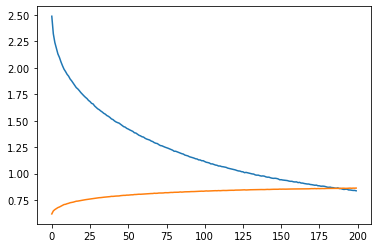

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

In [32]:
answer_vocab = answer_vectorization.get_vocabulary()
answer_index_lookup = dict(zip(range(len(answer_vocab)), answer_vocab))
max_decoded_sentence_length = 100


def decode_sequence(input_sentence):
    tokenized_input_sentence = question_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = answer_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = answer_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_questions = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_questions)
    solved = decode_sequence(input_sentence)
    print(input_sentence + '\n')
    print(solved + '\n')

Bob spends $27000 distributed between 3 schools to buy books.  He can buy 100 books for $500.  How many books can he buy per school?

[start] he dropped two dimes and increased the times a the difference in 35 66 [UNK] because now because 105 x 2 x 2 x 2 x 2 x 2 x four times a quarters he increased cost [UNK] 3 x four times a quarters he had [UNK] 3 the quarters he increased 12 x quarters he increased 12 x quarters he increased the quarters he increased the quarters 75 quarters 75 quarters 75 quarters 75 quarters 75 quarters matt in dimes humans [UNK] 3 the quarters he increased 12 x dimes discount on in dimes humans [UNK] 3 nickels he

Two cars are driving on a highway.  The first car is traveling at an average speed of 60 miles per hour when the second car passes it at an average speed of 70 miles per hour.  If both cars continue on the highway at the same speed, how many miles will separate them after 2 hours?

[start] the first season is broken second 4 2 [UNK] the second store wil